Задача предсказания магнитуды по датасету землетрясений
-----------------

In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error
data = pd.read_csv('Global_Earthquake_Data.csv')
data.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2023-02-26T23:58:05.052Z,41.8050,79.8675,10.000,5.0,mb,46.0,91.0,1.293,0.80,...,2023-02-27T00:11:38.040Z,"77 km NNW of Aksu, China",earthquake,6.59,1.897,0.078,52.0,reviewed,us,us
1,2023-02-26T23:33:17.641Z,18.7420,145.4868,200.365,4.8,mb,67.0,85.0,5.158,0.95,...,2023-02-26T23:58:32.040Z,"Pagan region, Northern Mariana Islands",earthquake,10.27,7.539,0.043,165.0,reviewed,us,us
2,2023-02-26T21:42:14.541Z,42.0857,79.9516,10.000,4.9,mb,45.0,77.0,1.223,0.82,...,2023-02-27T00:21:32.040Z,NaN,earthquake,6.27,1.869,0.086,42.0,reviewed,us,us
3,2023-02-26T21:35:01.303Z,14.9364,-104.5563,10.000,4.6,mb,51.0,217.0,5.661,0.57,...,2023-02-26T22:25:29.040Z,northern East Pacific Rise,earthquake,11.79,1.984,0.038,205.0,reviewed,us,us
4,2023-02-26T18:58:54.828Z,44.6730,146.5159,134.299,4.5,mb,108.0,62.0,2.866,0.82,...,2023-02-26T19:38:26.040Z,"84 km NE of Otrada, Russia",earthquake,8.66,5.863,0.059,84.0,reviewed,us,us


-----------------------------------------------------------------------------

Построим базовую модель(Baseline), в дальнейшем будем при проверке гипотез сравнивать с ней результаты

--------------------------------------------------------------------------

• time : Время возникновения землетрясения. Содержится в формате DD.MM.YY H:mm:ss\
• depth : Глубина эпицентра землетрясения в километрах\
• mag : Магнитуда. Это числовая оценка силы землетрясения, которая измеряется на основе сейсмических волн, вызванных землетрясением. В единицах по шкале Рихтера.\
• nst : Количество станций, которые зарегистрировали землетрясение.\
• gap : угол между двумя линиями, которые соединяют эпицентр землетрясения и наблюдательные станции на земной поверхности.\
• dmin : расстояние от эпицентра землетрясения до ближайшей станции сейсмической сети, которая зарегистрировала это землетрясение.\
• rms : Cреднее значение квадрата амплитуды всех зарегистрированных сейсмических волн в течение определенного временного интервала.\
• latitude : Значение широты.\
• longitude : Значение долготы.\
• horizontalError : показывает максимальное расстояние, на которое может быть смещен эпицентр землетрясения от первоначально определенного местоположения.\
• depthError : показывает максимальное расстояние, на которое может быть смещена глубина эпицентра землетрясения от первоначально определенной глубины.\
• magError : показывает разницу между первоначально определенной магнитудой землетрясения и магнитудой, полученной при переоценке землетрясения на основе более дополнительных данных.

Признаки для дропа при построении базовой модели:\
place - слишком трудный для обработки признак, он легко заменяется долготой и широтой\
horizontalError, depthError, magError - слишком много NaN, при этом не несет сильного смысла в себе\
id - также категориальный, не несущий смысла\
status - также бесполезен для предсказания магнитуды\
gap - насколько это понятно(для меня) нелинейно выражается через depth\
time - не влияет на магнитуду(целевую) + сложно интерпретировать\
magSource, locationSource - категориальный и очень большой по размерности, при ОН-кодировании каждого возникнет как минимум по 6 лишних стобцов, сликом "зашумит модель"\
updated - бесполезный\
###
dmin - пока удалим, хотя свиду признак важный

In [2]:
to_drop = ['place', 'horizontalError', 'depthError', \
           'magError', 'id', 'status', 'gap', 'time',\
            'magSource', 'locationSource', 'dmin', \
            'updated']
nan_to_mean = ['rms', 'nst', 'depth', 'rms', 'magNst']
cat_feat = ['magType', 'net', 'type']
def preprocessing(data, to_drop, nan_to_mean):
    data.drop(to_drop, axis = 1, inplace = True)
    for col_name in nan_to_mean:
        data[col_name].fillna(data[col_name].median(), inplace=True)
preprocessing(data, to_drop, nan_to_mean)
data['magType'].fillna('mb', inplace=True)

Посмотрим распределения признаков

array([[<Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'depth'}>],
       [<Axes: title={'center': 'mag'}>, <Axes: title={'center': 'nst'}>,
        <Axes: title={'center': 'rms'}>],
       [<Axes: title={'center': 'magNst'}>, <Axes: >, <Axes: >]],
      dtype=object)

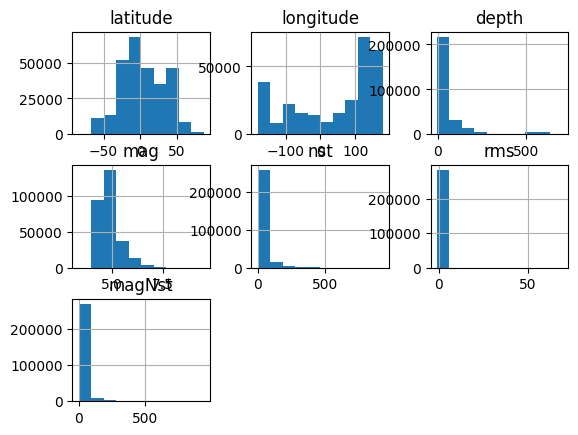

In [3]:
data.hist()

<Axes: >

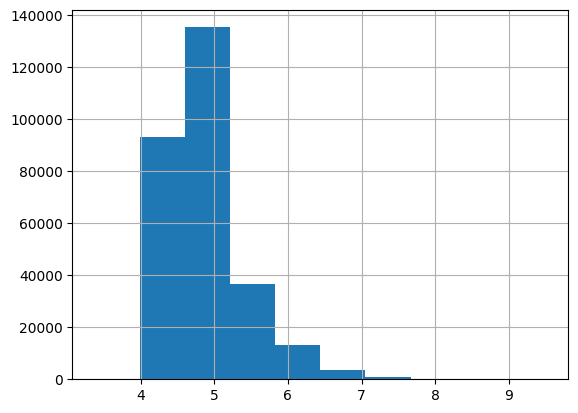

In [14]:
data.mag.hist()

In [15]:
print(f'Ширина диапазона значений - {data.mag.max() - data.mag.min()}')
print(f'Максимальное значение - {data.mag.max()}')
print(f'Минимальное значение - {data.mag.min()}')
print(f'Среднее значение - {data.mag.mean()}')
print(f'Медиана - {data.mag.median()}')
print(f'Мода - {float(data.mag.mode().values)}')
print(f'Среднеквадратичное отклонение - {data.mag.std()}')

Ширина диапазона значений - 6.12
Максимальное значение - 9.5
Минимальное значение - 3.38
Среднее значение - 4.941264675133859
Медиана - 4.8
Мода - 4.5
Среднеквадратичное отклонение - 0.48601960685901535


Целевая переменная mag имеет приближенное к лог-нормальному распределение, попробуем прологарифмировать

<Axes: >

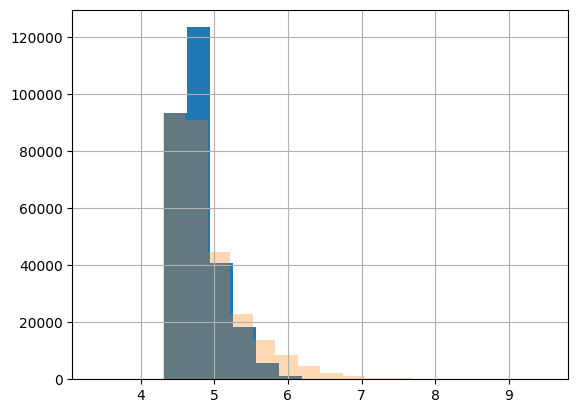

In [20]:
logged_mag = np.log(data.mag)
logged_mag.apply(lambda x: x*3.03).hist(bins = 10)
data.mag.hist(bins=20, alpha = 0.3)

!МАСШТАБ НЕ СОХРАНЕН!
Хвост распределения таргета стал менее протяженным, это может улучшить скор\
Отсюда гипотеза: логарифмирование целевой переменной даст прирост результата\
Проверим гипотезу, но сначала построим бейзлайн на базе катбуста с встроенной кодировкой категориальных признаков\
\
Проверять точность модели будем по кросс-валидации на 3 фолдах

In [92]:
X, y = data.drop('mag', axis = 1), data.mag
model = CatBoostRegressor(cat_features=cat_feat, loss_function='MAE', verbose=0)
kfold = KFold(n_splits=3, shuffle=True)
cv_scores = cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_absolute_error', verbose=2).mean()
-cv_scores

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time= 1.6min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min remaining:    0.0s


[CV] END .................................................... total time= 1.6min
[CV] END .................................................... total time= 1.6min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.8min finished


0.18370439682304565

Точность бейзлайна на кросс-валидации: 0.18370439682304565\
Проверим гипотезу о логарифмировании

In [93]:
from sklearn.model_selection import cross_val_predict
X, y = data.drop('mag', axis = 1), np.log(data.mag)
model = CatBoostRegressor(cat_features=cat_feat, loss_function='MAE', verbose=0)
kfold = KFold(n_splits=3, shuffle=True)
y_log_pred = cross_val_predict(model, X, y, cv=kfold, verbose=2)
y_pred = np.exp(y_log_pred)

# Вычисление метрики на каждом фолде
scores = []
for fold_idx, (train_idx, val_idx) in enumerate(kfold.split(X)):
    y_val = np.exp(y[val_idx])
    fold_score = mean_absolute_error(y_val, y_pred[val_idx])
    scores.append(fold_score)

# Вычисление среднего значения метрики
mean_score = np.mean(scores)

# Вывод результатов
print('Mean MAE:', mean_score)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.5min remaining:    0.0s


Mean MAE: 0.1836483515806053


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.6min finished


Точность бейзлайна с логарифмированием на кросс валидации: 0.1836483515806053\
Логарифмирование не дало прироста для модели градиентного бустинга, так как они могут работать с любым распределением данных, но проверить стоило\
**В дальнейшем будем не использовать логарифмирование**

-----------------------------------------

Углубимся в анализ данных

Заново загрузим датасет и посмотрим на имеющиеся признаки

In [237]:
df = pd.read_csv('Global_Earthquake_Data.csv')
df

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2023-02-26T23:58:05.052Z,41.8050,79.8675,10.000,5.00,mb,46.0,91.0,1.293,0.80,...,2023-02-27T00:11:38.040Z,"77 km NNW of Aksu, China",earthquake,6.59,1.897,0.078,52.0,reviewed,us,us
1,2023-02-26T23:33:17.641Z,18.7420,145.4868,200.365,4.80,mb,67.0,85.0,5.158,0.95,...,2023-02-26T23:58:32.040Z,"Pagan region, Northern Mariana Islands",earthquake,10.27,7.539,0.043,165.0,reviewed,us,us
2,2023-02-26T21:42:14.541Z,42.0857,79.9516,10.000,4.90,mb,45.0,77.0,1.223,0.82,...,2023-02-27T00:21:32.040Z,NaN,earthquake,6.27,1.869,0.086,42.0,reviewed,us,us
3,2023-02-26T21:35:01.303Z,14.9364,-104.5563,10.000,4.60,mb,51.0,217.0,5.661,0.57,...,2023-02-26T22:25:29.040Z,northern East Pacific Rise,earthquake,11.79,1.984,0.038,205.0,reviewed,us,us
4,2023-02-26T18:58:54.828Z,44.6730,146.5159,134.299,4.50,mb,108.0,62.0,2.866,0.82,...,2023-02-26T19:38:26.040Z,"84 km NE of Otrada, Russia",earthquake,8.66,5.863,0.059,84.0,reviewed,us,us
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283127,1906-01-21T13:49:33.570Z,34.1750,138.0250,300.000,7.40,mw,NaN,NaN,NaN,NaN,...,2022-04-25T20:24:35.887Z,"50 km SSW of ?yama, Japan",earthquake,NaN,25.000,0.300,NaN,reviewed,iscgem,iscgem
283128,1906-01-09T23:04:45.570Z,49.2560,18.4210,15.000,5.63,mw,NaN,NaN,NaN,NaN,...,2022-04-25T20:36:39.809Z,"10 km WNW of Byt?a, Slovakia",earthquake,NaN,3.500,0.650,NaN,reviewed,iscgem,iscgem
283129,1906-01-08T00:15:00.000Z,39.3000,-96.6000,NaN,4.90,fa,NaN,NaN,NaN,NaN,...,2018-06-04T20:43:44.000Z,Kansas,earthquake,NaN,NaN,NaN,NaN,reviewed,ushis,bar
283130,1906-01-06T21:31:33.220Z,53.4180,170.1000,35.000,6.58,mw,NaN,NaN,NaN,NaN,...,2022-04-25T20:39:47.898Z,"216 km WNW of Attu Station, Alaska",earthquake,NaN,3.500,0.200,NaN,reviewed,iscgem,iscgem


In [238]:
df.dtypes

time                object
latitude           float64
longitude          float64
depth              float64
mag                float64
magType             object
nst                float64
gap                float64
dmin               float64
rms                float64
net                 object
id                  object
updated             object
place               object
type                object
horizontalError    float64
depthError         float64
magError           float64
magNst             float64
status              object
locationSource      object
magSource           object
dtype: object

In [239]:
df.isna().sum()

time                    0
latitude                0
longitude               0
depth                 592
mag                     0
magType                 1
nst                188836
gap                138772
dmin               212029
rms                 48317
net                     0
id                      0
updated                 0
place                 847
type                    0
horizontalError    219119
depthError         136863
magError           198246
magNst              85130
status                  0
locationSource          0
magSource               0
dtype: int64

Как уже было написано при отборе признаков для бейзлайна есть признаки имеющие большое количество пропусков:\
horizontalError    219119\
dmin               212029\
magError           198246\
nst                188836\
gap                138772\
depthError         136863\
magNst              85130\
Для того чтобы решить, что сделать с этими признаками посмотрим на матрицу корреляций числовых признаков и целевой переменной

<Axes: >

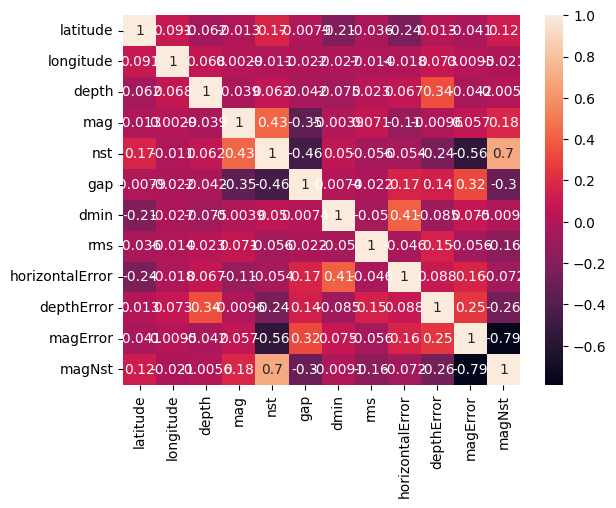

In [240]:
numeric = [col for col in df.columns if df[col].dtype != 'object']
corr = df[numeric].corr(method='kendall')
import seaborn as sb
sb.heatmap(corr, annot=True)

Удалим признаки horizontalError, dmin, magError, depthError так как они имеют огромное количество пропусков и не коррелируют с целевой переменной
Признаки id, time, status удалим из-за бесполезности для предсказания

In [241]:
df.drop(["horizontalError", "dmin", "magError", "depthError", "id", "time", "status", "updated"], axis=1, inplace=True)
df

,latitude,longitude,depth,mag,magType,nst,gap,rms,net,place,type,magNst,locationSource,magSource
0,41.8050,79.8675,10.000,5.00,mb,46.0,91.0,0.80,us,"77 km NNW of Aksu, China",earthquake,52.0,us,us
1,18.7420,145.4868,200.365,4.80,mb,67.0,85.0,0.95,us,"Pagan region, Northern Mariana Islands",earthquake,165.0,us,us
2,42.0857,79.9516,10.000,4.90,mb,45.0,77.0,0.82,us,NaN,earthquake,42.0,us,us
3,14.9364,-104.5563,10.000,4.60,mb,51.0,217.0,0.57,us,northern East Pacific Rise,earthquake,205.0,us,us
4,44.6730,146.5159,134.299,4.50,mb,108.0,62.0,0.82,us,"84 km NE of Otrada, Russia",earthquake,84.0,us,us
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283127,34.1750,138.0250,300.000,7.40,mw,NaN,NaN,NaN,iscgem,"50 km SSW of ?yama, Japan",earthquake,NaN,iscgem,iscgem
283128,49.2560,18.4210,15.000,5.63,mw,NaN,NaN,NaN,iscgem,"10 km WNW of Byt?a, Slovakia",earthquake,NaN,iscgem,iscgem
283129,39.3000,-96.6000,NaN,4.90,fa,NaN,NaN,NaN,ushis,Kansas,earthquake,NaN,ushis,bar
283130,53.4180,170.1000,35.000,6.58,mw,NaN,NaN,NaN,iscgem,"216 km WNW of Attu Station, Alaska",earthquake,NaN,iscgem,iscgem


Рассмотрим влияние категориальных признаков на целевую переменную

In [242]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))
cat_features = [col for col in df.columns if df[col].dtype == 'object' and col not in ['place', "locationSource", "magSource"]]
# print(cat_features)
corr_matrix = pd.DataFrame(index=cat_features, columns=['Correlation'])
for feature in cat_features:
    corr = cramers_v(data[feature], data['mag'])
    corr_matrix.loc[feature, 'Correlation'] = corr

# Вывод матрицы корреляций
print(corr_matrix)

        Correlation
magType    0.223934
net        0.341365
type        0.08443


В процессе подсчета не участвовали признаки locationSource, magSource так как они являются "указанием на источник данных", их мы отбросим, а признак place, я обработаю далее\
Посмотрим на признак type, видно что у признака >99% значений - earthquake, поэтому в датасете выберем строки со значением earthquake, и отбросим этот признак, таким образом мы будем работать только с данными по натуральным землятрясениям.

In [243]:
df.type.value_counts()

type
earthquake           282427
nuclear explosion       614
volcanic eruption        63
explosion                16
mine collapse             6
rock burst                3
other event               2
quarry blast              1
Name: count, dtype: int64

In [244]:
df = df[df.type == 'earthquake']
df.drop(["locationSource", "magSource", "type"], axis=1, inplace=True)
df

,latitude,longitude,depth,mag,magType,nst,gap,rms,net,place,magNst
0,41.8050,79.8675,10.000,5.00,mb,46.0,91.0,0.80,us,"77 km NNW of Aksu, China",52.0
1,18.7420,145.4868,200.365,4.80,mb,67.0,85.0,0.95,us,"Pagan region, Northern Mariana Islands",165.0
2,42.0857,79.9516,10.000,4.90,mb,45.0,77.0,0.82,us,NaN,42.0
3,14.9364,-104.5563,10.000,4.60,mb,51.0,217.0,0.57,us,northern East Pacific Rise,205.0
4,44.6730,146.5159,134.299,4.50,mb,108.0,62.0,0.82,us,"84 km NE of Otrada, Russia",84.0
...,...,...,...,...,...,...,...,...,...,...,...
283127,34.1750,138.0250,300.000,7.40,mw,NaN,NaN,NaN,iscgem,"50 km SSW of ?yama, Japan",NaN
283128,49.2560,18.4210,15.000,5.63,mw,NaN,NaN,NaN,iscgem,"10 km WNW of Byt?a, Slovakia",NaN
283129,39.3000,-96.6000,NaN,4.90,fa,NaN,NaN,NaN,ushis,Kansas,NaN
283130,53.4180,170.1000,35.000,6.58,mw,NaN,NaN,NaN,iscgem,"216 km WNW of Attu Station, Alaska",NaN


In [245]:
df.isna().sum()

latitude          0
longitude         0
depth           592
mag               0
magType           1
nst          188269
gap          138207
rms           47972
net               0
place           847
magNst        84867
dtype: int64

заполнить пропуски для числовых нет значения-уникальное значение\
для категориальных также\
сделать тестирование на том что выйдет без плейс\
закодировать плейс через tfidf с минимальным количеством фичей\
снова сделать тестирование\
подумать над дальнейшими действиями\

In [246]:
numeric = [col for col in df.columns if df[col].dtype != 'object']
df[numeric].isna().sum()

latitude          0
longitude         0
depth           592
mag               0
nst          188269
gap          138207
rms           47972
magNst        84867
dtype: int64

Проверим гипотезу:\
H0-заполнение пропущенных значений столбцов 'nst', 'gap', 'rms', 'magNst'  УНИКАЛЬНЫМ ЗНАЧЕНИЕМ даст прирост результата\
Это обосновано, так как бустинговые модели могут интерпретировать такие значения как особые категории


In [247]:
cols = ['nst', 'gap', 'rms', 'magNst']
# хочу заполнить -999, посмотрим есть ли такие в 
for col in cols: 
    print(-999 in df[col].unique())

False
False
False
False


In [248]:
df.depth.fillna(df.depth.mean(), inplace=True)
for col in cols:
    df[col].fillna(-999, inplace=True)

Посмотрим на категориальные признаки 

In [249]:
cat_feat = [col for col in df.columns if df[col].dtype =='object']
cat_feat

['magType', 'net', 'place']

In [250]:
df[cat_feat].isna().sum()

magType      1
net          0
place      847
dtype: int64

у нас всего один пропуск в magType - отлично(заполним самой частой категорией), признак place мы пока удалим!

In [251]:
df.magType.fillna('mb', inplace=True)
place_col = df.place
df.drop('place', axis=1, inplace=True)
df

,latitude,longitude,depth,mag,magType,nst,gap,rms,net,magNst
0,41.8050,79.8675,10.000000,5.00,mb,46.0,91.0,0.80,us,52.0
1,18.7420,145.4868,200.365000,4.80,mb,67.0,85.0,0.95,us,165.0
2,42.0857,79.9516,10.000000,4.90,mb,45.0,77.0,0.82,us,42.0
3,14.9364,-104.5563,10.000000,4.60,mb,51.0,217.0,0.57,us,205.0
4,44.6730,146.5159,134.299000,4.50,mb,108.0,62.0,0.82,us,84.0
...,...,...,...,...,...,...,...,...,...,...
283127,34.1750,138.0250,300.000000,7.40,mw,-999.0,-999.0,-999.00,iscgem,-999.0
283128,49.2560,18.4210,15.000000,5.63,mw,-999.0,-999.0,-999.00,iscgem,-999.0
283129,39.3000,-96.6000,69.967524,4.90,fa,-999.0,-999.0,-999.00,ushis,-999.0
283130,53.4180,170.1000,35.000000,6.58,mw,-999.0,-999.0,-999.00,iscgem,-999.0


Мы полностью обработали датасет, попробуем обучить модель!

In [ ]:
cat_feat = [col for col in df.columns if df[col].dtype =='object']
X, y = df.drop('mag', axis = 1), df.mag
model = CatBoostRegressor(cat_features=cat_feat, loss_function='MAE', verbose=0)
kfold = KFold(n_splits=3, shuffle=True)
cv_scores = cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_absolute_error', verbose=2).mean()
-cv_scores

Мы улучшили скор! Скор на кросс-валидации: 0.17482474469075035 против 0.18370439682304565 у бейзлайна

Проверим гипотезу: если с помощью nlp-методов закодировать столбце place - качество модели увеличится

In [253]:
df = pd.concat([df, place_col], axis=1)
df

,latitude,longitude,depth,mag,magType,nst,gap,rms,net,magNst,place
0,41.8050,79.8675,10.000000,5.00,mb,46.0,91.0,0.80,us,52.0,"77 km NNW of Aksu, China"
1,18.7420,145.4868,200.365000,4.80,mb,67.0,85.0,0.95,us,165.0,"Pagan region, Northern Mariana Islands"
2,42.0857,79.9516,10.000000,4.90,mb,45.0,77.0,0.82,us,42.0,NaN
3,14.9364,-104.5563,10.000000,4.60,mb,51.0,217.0,0.57,us,205.0,northern East Pacific Rise
4,44.6730,146.5159,134.299000,4.50,mb,108.0,62.0,0.82,us,84.0,"84 km NE of Otrada, Russia"
...,...,...,...,...,...,...,...,...,...,...,...
283127,34.1750,138.0250,300.000000,7.40,mw,-999.0,-999.0,-999.00,iscgem,-999.0,"50 km SSW of ?yama, Japan"
283128,49.2560,18.4210,15.000000,5.63,mw,-999.0,-999.0,-999.00,iscgem,-999.0,"10 km WNW of Byt?a, Slovakia"
283129,39.3000,-96.6000,69.967524,4.90,fa,-999.0,-999.0,-999.00,ushis,-999.0,Kansas
283130,53.4180,170.1000,35.000000,6.58,mw,-999.0,-999.0,-999.00,iscgem,-999.0,"216 km WNW of Attu Station, Alaska"


In [254]:
df.reset_index(drop=True, inplace=True)
df

,latitude,longitude,depth,mag,magType,nst,gap,rms,net,magNst,place
0,41.8050,79.8675,10.000000,5.00,mb,46.0,91.0,0.80,us,52.0,"77 km NNW of Aksu, China"
1,18.7420,145.4868,200.365000,4.80,mb,67.0,85.0,0.95,us,165.0,"Pagan region, Northern Mariana Islands"
2,42.0857,79.9516,10.000000,4.90,mb,45.0,77.0,0.82,us,42.0,NaN
3,14.9364,-104.5563,10.000000,4.60,mb,51.0,217.0,0.57,us,205.0,northern East Pacific Rise
4,44.6730,146.5159,134.299000,4.50,mb,108.0,62.0,0.82,us,84.0,"84 km NE of Otrada, Russia"
...,...,...,...,...,...,...,...,...,...,...,...
282422,34.1750,138.0250,300.000000,7.40,mw,-999.0,-999.0,-999.00,iscgem,-999.0,"50 km SSW of ?yama, Japan"
282423,49.2560,18.4210,15.000000,5.63,mw,-999.0,-999.0,-999.00,iscgem,-999.0,"10 km WNW of Byt?a, Slovakia"
282424,39.3000,-96.6000,69.967524,4.90,fa,-999.0,-999.0,-999.00,ushis,-999.0,Kansas
282425,53.4180,170.1000,35.000000,6.58,mw,-999.0,-999.0,-999.00,iscgem,-999.0,"216 km WNW of Attu Station, Alaska"


In [255]:
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
import warnings
warnings.filterwarnings("ignore")
def preprocess_text(text):
    text = re.sub(r"[^а-яА-ЯёЁa-zA-Z0-9]", " ", text)
    text = re.sub(r"\s+", " ", text)
    tokens = word_tokenize(text.lower(), language='russian')
    stop_words = set(stopwords.words("russian"))
    stop_words.remove('не')
    tokens = [word for word in tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)
df.place.fillna(' ', inplace=True)
df.place = df.place.apply(preprocess_text)
df

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\me\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,latitude,longitude,depth,mag,magType,nst,gap,rms,net,magNst,place
0,41.8050,79.8675,10.000000,5.00,mb,46.0,91.0,0.80,us,52.0,77 km nnw of aksu china
1,18.7420,145.4868,200.365000,4.80,mb,67.0,85.0,0.95,us,165.0,pagan region northern mariana island
2,42.0857,79.9516,10.000000,4.90,mb,45.0,77.0,0.82,us,42.0,
3,14.9364,-104.5563,10.000000,4.60,mb,51.0,217.0,0.57,us,205.0,northern east pacific rise
4,44.6730,146.5159,134.299000,4.50,mb,108.0,62.0,0.82,us,84.0,84 km ne of otrada russia
...,...,...,...,...,...,...,...,...,...,...,...
282422,34.1750,138.0250,300.000000,7.40,mw,-999.0,-999.0,-999.00,iscgem,-999.0,50 km ssw of yama japan
282423,49.2560,18.4210,15.000000,5.63,mw,-999.0,-999.0,-999.00,iscgem,-999.0,10 km wnw of byt a slovakia
282424,39.3000,-96.6000,69.967524,4.90,fa,-999.0,-999.0,-999.00,ushis,-999.0,kansa
282425,53.4180,170.1000,35.000000,6.58,mw,-999.0,-999.0,-999.00,iscgem,-999.0,216 km wnw of attu station alaska


In [256]:
vectorizer = TfidfVectorizer(max_features=10)
content_transformed = vectorizer.fit_transform(df.place)
content = pd.DataFrame.sparse.from_spmatrix(content_transformed)
clms = [str(i) for i in range(content.shape[1])]
content.columns=clms
content

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,0.000000,0.000000,0.730527,0.0,0.682883,0.000000,0.0
1,0.0,0.0,0.0,0.640145,0.000000,0.000000,0.0,0.000000,0.768254,0.0
2,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
3,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
4,0.0,0.0,0.0,0.000000,0.000000,0.730527,0.0,0.682883,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...
282422,0.0,0.0,0.0,0.000000,0.888079,0.335817,0.0,0.313916,0.000000,0.0
282423,0.0,0.0,0.0,0.000000,0.000000,0.730527,0.0,0.682883,0.000000,0.0
282424,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
282425,0.0,0.0,0.0,0.000000,0.000000,0.730527,0.0,0.682883,0.000000,0.0


In [257]:
df = pd.concat([df.drop('place', axis = 1), content], axis=1)
df

,latitude,longitude,depth,mag,magType,nst,gap,rms,net,magNst,0,1,2,3,4,5,6,7,8,9
0,41.8050,79.8675,10.000000,5.00,mb,46.0,91.0,0.80,us,52.0,0.0,0.0,0.0,0.000000,0.000000,0.730527,0.0,0.682883,0.000000,0.0
1,18.7420,145.4868,200.365000,4.80,mb,67.0,85.0,0.95,us,165.0,0.0,0.0,0.0,0.640145,0.000000,0.000000,0.0,0.000000,0.768254,0.0
2,42.0857,79.9516,10.000000,4.90,mb,45.0,77.0,0.82,us,42.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
3,14.9364,-104.5563,10.000000,4.60,mb,51.0,217.0,0.57,us,205.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
4,44.6730,146.5159,134.299000,4.50,mb,108.0,62.0,0.82,us,84.0,0.0,0.0,0.0,0.000000,0.000000,0.730527,0.0,0.682883,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282422,34.1750,138.0250,300.000000,7.40,mw,-999.0,-999.0,-999.00,iscgem,-999.0,0.0,0.0,0.0,0.000000,0.888079,0.335817,0.0,0.313916,0.000000,0.0
282423,49.2560,18.4210,15.000000,5.63,mw,-999.0,-999.0,-999.00,iscgem,-999.0,0.0,0.0,0.0,0.000000,0.000000,0.730527,0.0,0.682883,0.000000,0.0
282424,39.3000,-96.6000,69.967524,4.90,fa,-999.0,-999.0,-999.00,ushis,-999.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
282425,53.4180,170.1000,35.000000,6.58,mw,-999.0,-999.0,-999.00,iscgem,-999.0,0.0,0.0,0.0,0.000000,0.000000,0.730527,0.0,0.682883,0.000000,0.0


Мы присоединили к датасету tf-idf матрицу признака place, попробуем обучить модель и посмотреть на прирост

In [258]:
cat_feat = [col for col in df.columns if df[col].dtype =='object']
X, y = df.drop('mag', axis = 1), df.mag
model = CatBoostRegressor(cat_features=cat_feat, loss_function='MAE', verbose=0)
kfold = KFold(n_splits=3, shuffle=True)
cv_scores = cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_absolute_error', verbose=2).mean()
-cv_scores

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time= 2.4min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.4min remaining:    0.0s


[CV] END .................................................... total time= 2.4min
[CV] END .................................................... total time= 2.4min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  7.2min finished


0.17484876486418569

Модель с закодированным текстом через tf-idf показала ошибку 0.17484876486418569 против 0.17482474469075035 у лучшей модели, то есть влияния практически нет

------------------

**Составим полный пайплайн модели и попробуем отобрать гиперпараметры через optuna**

In [3]:
# предобработка датасета
df = pd.read_csv('Global_Earthquake_Data.csv')
df.drop(["horizontalError", "dmin", "magError", "depthError", "id", "time", "status", "updated"], axis=1, inplace=True)
df = df[df.type == 'earthquake']
df.drop(["locationSource", "magSource", "type"], axis=1, inplace=True)
numeric = [col for col in df.columns if df[col].dtype != 'object']
cols = ['nst', 'gap', 'rms', 'magNst']
df.depth.fillna(df.depth.mean(), inplace=True)
for col in cols:
    df[col].fillna(-999, inplace=True)
df.magType.fillna('mb', inplace=True)
df.drop('place', axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)
cat_feat = [col for col in df.columns if df[col].dtype =='object']
X, y = df.drop('mag', axis = 1), df.mag
X

,latitude,longitude,depth,magType,nst,gap,rms,net,magNst
0,41.8050,79.8675,10.000000,mb,46.0,91.0,0.80,us,52.0
1,18.7420,145.4868,200.365000,mb,67.0,85.0,0.95,us,165.0
2,42.0857,79.9516,10.000000,mb,45.0,77.0,0.82,us,42.0
3,14.9364,-104.5563,10.000000,mb,51.0,217.0,0.57,us,205.0
4,44.6730,146.5159,134.299000,mb,108.0,62.0,0.82,us,84.0
...,...,...,...,...,...,...,...,...,...
282422,34.1750,138.0250,300.000000,mw,-999.0,-999.0,-999.00,iscgem,-999.0
282423,49.2560,18.4210,15.000000,mw,-999.0,-999.0,-999.00,iscgem,-999.0
282424,39.3000,-96.6000,69.967524,fa,-999.0,-999.0,-999.00,ushis,-999.0
282425,53.4180,170.1000,35.000000,mw,-999.0,-999.0,-999.00,iscgem,-999.0


In [264]:
import optuna
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 0.1, 10.0),
        "cat_features": cat_feat
    }

    model = CatBoostRegressor(**params, verbose=0)
    model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=10)
    y_pred = model.predict(X_val)
    score = mean_absolute_error(y_val, y_pred)

    return score

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Best trial:', study.best_trial.params)
print('Best score:', study.best_value)


[I 2023-06-04 22:19:48,954] A new study created in memory with name: no-name-2b929c77-d3f2-4f89-8cb4-aab6b30447e2
[I 2023-06-04 22:20:51,578] Trial 0 finished with value: 0.18165428589247085 and parameters: {'iterations': 824, 'depth': 5, 'learning_rate': 0.026591387503045332, 'l2_leaf_reg': 1.6912649567317868}. Best is trial 0 with value: 0.18165428589247085.
[I 2023-06-04 22:21:34,088] Trial 1 finished with value: 0.18320774627823477 and parameters: {'iterations': 888, 'depth': 3, 'learning_rate': 0.05576014056376462, 'l2_leaf_reg': 0.2906878611160701}. Best is trial 0 with value: 0.18165428589247085.
[I 2023-06-04 22:22:19,212] Trial 2 finished with value: 0.1804379932686196 and parameters: {'iterations': 590, 'depth': 5, 'learning_rate': 0.04778905764370935, 'l2_leaf_reg': 0.1518178676702515}. Best is trial 2 with value: 0.1804379932686196.
[I 2023-06-04 22:22:55,509] Trial 3 finished with value: 0.18726059517412513 and parameters: {'iterations': 406, 'depth': 6, 'learning_rate': 0

Best trial: {'iterations': 920, 'depth': 10, 'learning_rate': 0.09439322060119908, 'l2_leaf_reg': 3.653275912646473}
Best score: 0.1709006722771077


попробуем перебрать и другие гиперпараметры

In [4]:
import optuna
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 700, 2000),
        'depth': trial.suggest_int('depth', 8, 14),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.1),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 3.0, 10.0),
        'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.1, 10.0),
        'border_count': trial.suggest_int('border_count', 32, 256),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'cat_features': cat_feat
    }

    model = CatBoostRegressor(**params, verbose=0)
    model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=10)
    y_pred = model.predict(X_val)
    score = mean_absolute_error(y_val, y_pred)

    return score

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)
print('Best trial:', study.best_trial.params)
print('Best score:', study.best_value)


[I 2023-06-05 09:06:19,045] A new study created in memory with name: no-name-a76f9cc0-c9a2-4653-be25-6d39eb58efbc
C:\Users\me\AppData\Local\Temp\ipykernel_25864\495892187.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.1),
C:\Users\me\AppData\Local\Temp\ipykernel_25864\495892187.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 3.0, 10.0),
C:\Users\me\AppData\Local\Temp\ipykernel_25864\495892187.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use

Best trial: {'iterations': 1998, 'depth': 11, 'learning_rate': 0.07034117417854266, 'l2_leaf_reg': 3.0128866968183394, 'bagging_temperature': 1.844972844267103, 'border_count': 222, 'grow_policy': 'SymmetricTree'}
Best score: 0.17060853059220596


Лучшие гиперпараметры подобраны, давайте обучим модель и посмотрим на ее качество на кросс-валидации

In [6]:
cat_feat = [col for col in df.columns if df[col].dtype =='object']
X, y = df.drop('mag', axis = 1), df.mag
model = CatBoostRegressor(cat_features=cat_feat, loss_function='MAE',\
                           verbose=1, iterations=1998, depth=11, learning_rate=0.07,\
                            l2_leaf_reg=3, bagging_temperature=1.9, border_count=222,\
                             grow_policy= 'SymmetricTree')
kfold = KFold(n_splits=3, shuffle=True)
cv_scores = cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_absolute_error', verbose=2).mean()
-cv_scores

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0:	learn: 0.3205010	total: 304ms	remaining: 10m 6s
1:	learn: 0.3076032	total: 584ms	remaining: 9m 43s
2:	learn: 0.2954714	total: 886ms	remaining: 9m 49s
3:	learn: 0.2847262	total: 1.19s	remaining: 9m 54s
4:	learn: 0.2747377	total: 1.48s	remaining: 9m 51s
5:	learn: 0.2655511	total: 1.77s	remaining: 9m 49s
6:	learn: 0.2572635	total: 1.99s	remaining: 9m 25s
7:	learn: 0.2494352	total: 2.19s	remaining: 9m 4s
8:	learn: 0.2426303	total: 2.38s	remaining: 8m 47s
9:	learn: 0.2364167	total: 2.58s	remaining: 8m 31s
10:	learn: 0.2311448	total: 2.78s	remaining: 8m 21s
11:	learn: 0.2261911	total: 2.97s	remaining: 8m 12s
12:	learn: 0.2218648	total: 3.17s	remaining: 8m 3s
13:	learn: 0.2178223	total: 3.38s	remaining: 7m 58s
14:	learn: 0.2144019	total: 3.6s	remaining: 7m 55s
15:	learn: 0.2113842	total: 3.81s	remaining: 7m 51s
16:	learn: 0.2084173	total: 4.02s	remaining: 7m 48s
17:	learn: 0.2060035	total: 4.24s	remaining: 7m 46s
18:	learn: 0.2036742	total: 4.45s	remaining: 7m 43s
19:	learn: 0.2017003	tota

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.3min remaining:    0.0s


0:	learn: 0.3183708	total: 214ms	remaining: 7m 7s
1:	learn: 0.3058195	total: 403ms	remaining: 6m 42s
2:	learn: 0.2940097	total: 581ms	remaining: 6m 26s
3:	learn: 0.2830812	total: 770ms	remaining: 6m 23s
4:	learn: 0.2728448	total: 951ms	remaining: 6m 19s
5:	learn: 0.2636260	total: 1.13s	remaining: 6m 16s
6:	learn: 0.2553715	total: 1.32s	remaining: 6m 17s
7:	learn: 0.2477216	total: 1.51s	remaining: 6m 16s
8:	learn: 0.2409902	total: 1.7s	remaining: 6m 15s
9:	learn: 0.2349512	total: 1.88s	remaining: 6m 14s
10:	learn: 0.2295507	total: 2.06s	remaining: 6m 12s
11:	learn: 0.2247034	total: 2.24s	remaining: 6m 10s
12:	learn: 0.2206637	total: 2.42s	remaining: 6m 9s
13:	learn: 0.2168115	total: 2.59s	remaining: 6m 7s
14:	learn: 0.2133197	total: 2.77s	remaining: 6m 6s
15:	learn: 0.2101564	total: 2.94s	remaining: 6m 4s
16:	learn: 0.2074152	total: 3.13s	remaining: 6m 5s
17:	learn: 0.2049896	total: 3.32s	remaining: 6m 5s
18:	learn: 0.2028058	total: 3.51s	remaining: 6m 5s
19:	learn: 0.2007577	total: 3.7

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 19.1min finished


0.16898629268946053

На кросс валидации наша модель показала отличный результат: MAE: **0.169**, это серьезное улучшение в сравнении с бейслайном MAE: **0.1837**
